# TelexRAG: Hungarian News Analysis System

> **System Overview**  
This notebook implements an intelligent research and analysis system designed for Hungarian news articles from [Telex.hu](https://telex.hu). It integrates **agentic workflows** to automate both search and reporting tasks.

The system consists of:

1. **Retrieval-Augmented Generation (RAG) Agent** — Automatically retrieves, analyzes, and summarizes relevant articles from Telex.hu.
2. **Visualization Agent** — Formats the analytical results into a clear and structured HTML report for easy consumption.

This agentic system leverages **LangChain’s StateGraph architecture** to modularize tasks and allow autonomous reasoning over Hungarian news data.

## Environment Setup

This segment initializes the necessary libraries, environment variables, and configurations to support the **agentic TelexRAG system**. Here’s how each part relates to the architecture:

- **Core Libraries (os, json, typing)** — Handle standard Python utilities and type annotations.
- **Display Utilities (IPython)** — Allow rendering of HTML outputs and images within the notebook (used by the visualization agent).
- **LLM Integrations (LangChain OpenAI & Google GenAI)** — Enable interaction with large language models (LLMs), which power the **RAG agent** and its reasoning capabilities.
- **Custom Module (TelexScraper)** — A scraper tailored for extracting articles from Telex.hu, feeding raw data into the agent system.
- **LangGraph Components (StateGraph, ReAct agent)** — The backbone of the **agentic system**, allowing for structured multi-step workflows that:
  - Retrieve articles
  - Analyze content
  - Format results
- **LangSmith Tracing Utility** — Optional observability tool to monitor and debug agent reasoning steps.
- **Environment Variables (.env)** — Securely loads API keys necessary to access OpenAI and Google LLMs.

This setup ensures that the **agentic workflows** can operate seamlessly, securely, and reproducibly within this notebook.


In [940]:
# === Core Libraries ===
import os
import json
from typing import List, Dict, Any, Optional, Annotated
from typing_extensions import TypedDict

# === Display & Visualization Utilities ===
from IPython.display import HTML, display, Image

# === LangChain LLM Integrations ===
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate

# === Custom Modules ===
from telex_scraper import TelexScraper

# === LangGraph Agentic System Components ===
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent
from langgraph.graph.message import add_messages

# === Environment Variables ===
from dotenv import load_dotenv
load_dotenv()

# === LangSmith Tracing Utility (for debugging/observability) ===
from langsmith import utils
utils.tracing_is_enabled()

# === API Keys ===
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")


## Core Functions for Article Retrieval and Analysis

This segment defines two **utility functions** that act as the primary _data acquisition layer_ for the TelexRAG agentic system.

- These functions are **tools** accessible by the **RAG agent** to autonomously retrieve relevant data from Telex.hu.

### `search_telex_articles(query, max_results)`
- **Purpose**: Searches Telex.hu for articles matching a user-provided query.
- **Output**: A formatted string listing the top article titles, dates, and URLs.

### `scrape_article(url)`
- **Purpose**: Extracts full article content from a given Telex.hu article URL.
- **Output**: A formatted string containing the article’s title, date, URL, and full content.

Both functions provide **structured inputs** for the agentic workflows to reason over and analyze.


In [941]:
# Searches for articles on Telex.hu
def search_telex_articles(query: str, max_results: int = 5) -> str:
    """
    Search Telex.hu for news articles matching a query.

    Parameters
    ----------
    query : str
        The search term to find relevant articles.
    max_results : int, default=5
        The maximum number of articles to return.

    Returns
    -------
    str
        A formatted string listing article titles, dates, and URLs.
    """
    # Format the query as a dictionary for the scraper
    query_dict = {"query": query, "max_articles": max_results}

    articles = TelexScraper.search_articles(query_dict, max_results)

    if not articles:
        return "No articles found matching your query."

    results = "Found the following articles:\n\n"
    for i, article in enumerate(articles, 1):
        results += f"{i}. {article['title']}\n"
        results += f"   Date: {article['date']}\n"
        results += f"   URL: {article['url']}\n\n"

    return results


# Scrapes the content of a specific article
def scrape_article(url: str) -> str:
    """
    Scrape and return the content of a specific Telex.hu article.

    Parameters
    ----------
    url : str
        The URL of the article to scrape.

    Returns
    -------
    str
        A formatted string containing the article title, date, URL, and content.
    """
    if not url.startswith("https://telex.hu"):
        return "Error: Only Telex.hu URLs are supported."

    article = TelexScraper.scrape_article_content(url)

    result = f"Title: {article['title']}\n"
    result += f"Date: {article['date']}\n"
    result += f"URL: {article['url']}\n\n"
    result += f"Content:\n{article['content']}"

    return result


## Fetch and Analyze Articles

This higher-level utility function **combines search + scrape + filter** steps into a single operation, streamlining the input pipeline for the **RAG agent**.

### `fetch_and_analyze_articles(query, topic_filter, max_articles)`
- **Purpose**: Automates the process of:
  1. Searching for articles from the internet in real time
  2. Scraping their full text
  3. Filtering them by an optional topic keyword
- **Relation to Agentic System**:  
  This is the **primary tool** the RAG agent invokes to acquire rich contextual datasets (curated articles) for analysis.
- **Output**: A list of dictionaries:
  ```python
  {
      "title": str,
      "url": str,
      "content": str
  }


In [942]:
# Searches for articles and scrapes their content
def fetch_and_analyze_articles(
    query: str, topic_filter: Optional[str] = None, max_articles: int = 5
) -> List[Dict[str, Any]]:
    """
    Search for articles, scrape their content, and analyze them using a Retrieval-Augmented Generation (RAG) system.

    Parameters
    ----------
    query : str
        The search query to find relevant articles.
    topic_filter : Optional[str], default=None
        An optional keyword or topic to further filter the articles' content.
    max_articles : int, default=5
        The maximum number of articles to retrieve and analyze.

    Returns
    -------
    List[Dict[str, str]]
        A list of dictionaries, each containing:
            {
                "title": str,
                "url": str,
                "content": str
            }
    """
    print(f"Searching for articles related to: {query}")

    # Format the query as a dictionary for the scraper
    query_dict = {"query": query, "max_articles": max_articles}

    articles = TelexScraper.search_articles(query_dict, max_results=max_articles)

    if not articles:
        return "No articles found matching your query."

    print(f"Found {len(articles)} articles. Scraping content...")

    # Scrape content for all articles
    article_contents = []
    for article in articles:
        content = TelexScraper.scrape_article_content(article["url"])
        if topic_filter and topic_filter.lower() not in content["content"].lower():
            continue
        article_contents.append(content)

    if not article_contents:
        return f"No articles found matching both the query and the topic filter: {topic_filter}"

    print(f"Processing {len(article_contents)} articles...")

    return article_contents

## LangGraph State Definition

The **`State` class** defines the **memory schema** of the agentic system.  
This schema acts as a **shared workspace** between all agent nodes in the LangGraph workflow.

### `class State(TypedDict)`
- **Purpose**: Explicitly defines all variables (memory slots) that will persist across nodes in the **LangGraph**.
- **Relation to Agentic System**:  
  It is the **backbone of memory**, ensuring all sub-agents (tools and nodes) can access, mutate, and reason over a shared context.

### Memory Slots
| Field           | Description                               |
|-----------------|-------------------------------------------|
|   `messages`    | Messages between human and Ai.            |
| `visualization` | Final generated HTML page.                |

By formally specifying these slots, **LangGraph** guarantees **structured, consistent information sharing** between the autonomous agents.

In this solution the rag_agent is created with the create_react_agent method, an alternate solution would be to create that agent inside another function, add that to the graph as a node and create a field in State corresponding to its output.


In [943]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    visualization: str

## Templates

These templates power a two-stage system for processing Hungarian news:

### RAG Agent Template

This template configures a retrieval agent specialized for Hungarian news that:
- Retrieves and processes articles from Telex.hu based on user queries
- Translates titles and content to match the user's language
- Summarizes articles (default: 3, user-adjustable)
- Uses various tools (referenced as `{tools}`) for retrieval operations

### HTML Generation Agent Template

This template defines a presentation agent that:
- Transforms processed news data into styled HTML
- Creates a floating card layout that visually mimics Telex.hu's design
- Includes specific styling guidelines (colors, typography, spacing)
- Ensures responsive design with proper content organization



In [944]:
# Create a React-compatible prompt template for the RAG agent
rag_template = """You are an intelligent research agent specialized in Hungarian news analysis.
Your goal is to help users find, retrieve, and summarize news articles from Telex.hu.
Make sure that both the title and the content is translated to the query language.
By default summarize 3 articles, but if the user specifies a number, use that instead.
You have access to these tools:
{tools}

Begin!
"""

# Define the system prompt for the HTML generation agent
html_system_template = """You are a front-end presentation AI specializing in replicating the Telex.hu news site visual design within a floating card layout.

Your job is to convert the input text into an HTML presentation that matches the Telex.hu website style, contained within a single rounded card.

---

**Your Core Responsibilities:**

1. **Create a floating card layout:**
   - Place the entire Telex.hu styled content (including top navigation bar) inside a rounded card
   - Make the card have subtle shadows for a floating effect
   - Keep the page background transparent outside of the card
   - Give the card appropriate margins and maximum width for readability

2. **Match Telex.hu's visual design within the card:**
   - Use the exact Telex blue color scheme (#113355 for the top navigation bar)
   - Use Juana Black font for the Telex logo and similar sans-serif fonts for content
   - Maintain the clean, professional news site layout
   - Make the top navigation bar fill the top of the card and center the telex logo in it
   - Dont use any date on the card

3. **Technical Notes**:
   - Output must be valid HTML with embedded CSS
   - Dont use javascript or any external libraries
   - Make sure fonts are properly specified (use system fonts that approximate Telex's typography)
   - Ensure responsive design principles are followed
   - Include the date formatting used by Telex (YYYY. month DD. - day format)
   - Include a link to the original articles somewhere in the card like at the bottom or inside a keyword
   - The card should have proper padding inside and responsive sizing

---

**Color Palette:**
- Card Background: `#FFFFFF`
- Page Background: `transparent`
- Navigation Bar: `#113355` (top section of the card)
- Logo Text: `#FFFFFF` (white)
- Text: `#000000`
- Link/Accent: `#1E88E5`
- Section Headers: `#000000`
- Card Shadow: `rgba(0,0,0,0.1)` 

---

**Design Elements to Include**:
- Floating card with rounded corners (12-16px radius)
- Top navigation bar with Telex logo (contained within the card)
- Clear article headlines in larger font
- Author information with date
- Clean paragraph spacing
- Divide segments with dotted lines or subtle dividers
- Content sections with proper hierarchy
- Responsive design that works on different screen sizes

---

**Output Requirements**:
- Generate complete HTML that can be directly rendered
- Include all necessary inline CSS
- Match Telex.hu's layout and style as closely as possible within the card layout
- Organize content in a clean, readable format typical of a news site
- Ensure the card has proper spacing, shadow, and rounded corners
- Make sure to handle both cases: when article_data is a string (summary or message) or when it's a list of articles.
"""



## HTML Generation with LLM

This function generates a visually appealing HTML representation of news articles. It takes the output from the RAG agent (last message from State) and transforms it into an HTML visualization that mimics the Telex.hu design.

The function handles different input formats and cleans the data to prevent formatting issues:
- For text inputs: passes them directly to the LLM


In [945]:
# Initialize the HTML generation LLM with slightly higher temperature for creative design
html_llm = ChatOpenAI(
    model="gpt-4o-2024-08-06",
    temperature=0.2,
    api_key=os.environ.get("OPENAI_API_KEY"),
)


def create_html_with_llm(state: State) -> Dict[str, str]:
    articles_analysis = state["messages"][-1].content

    """
    Use an LLM agent to generate an HTML page from article analysis data.
    
    Parameters
    ----------
    articles_analysis : Any
        The output from the RAG agent, which could be a string or a list of dictionaries.
        
    Returns
    -------
    str
        An HTML string created by the LLM.
    """
    # Convert the input to a format that can be included in the prompt

    try:
        # Generate HTML using the LLM
        response = html_llm.invoke(
            [
                {"role": "system", "content": html_system_template},
                {"role": "user", "content": articles_analysis},
            ]
        )

        # Extract the HTML from the response
        html_content = response.content

        # Sometimes the LLM might wrap the HTML in markdown code blocks, so remove those if present
        html_content = html_content.replace("```html", "").replace("```", "").strip()

        return {"visualization": html_content}
    except Exception as e:
        print(f"Error generating HTML: {e}")


## Agentic Workflow Graph (LangGraph)

This is the **core agentic system** — where **autonomous workflows** are defined and orchestrated using **LangGraph**.

### Workflow Breakdown
| Node | Function | Output |
|------|----------|--------|
| `rag_agent` | Summarize articles + Search and Scrape using tool | Populates `state["messages"]` |
| `create_html_with_llm` | Visualize summarized  article contents | Populates `state["visualization"]` |

### Key Concepts

- **LangGraph** = Graph-based agent framework  
- **Nodes** = Autonomous functional blocks  
- **Edges** = Flow of execution (how agents collaborate)

### Relation to Agentic System

This **graph** defines the **autonomous reasoning chain**:
1. **Fetch knowledge** from Telex.hu
2. **Summarize** relevant information
3. Output a **clean summary** (ready for HTML rendering)

All agents communicate using the **shared `State` memory schema**.  
This architecture makes the system **modular**, **autonomous**, and **extensible** — new tools/nodes can be added effortlessly.




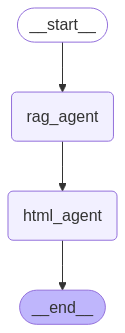

In [946]:
# Initialize LLM with Gemini
llm = ChatOpenAI(
    model="gpt-4o-2024-08-06",
    temperature=0,
    api_key=os.environ.get("OPENAI_API_KEY"),
)

rag_tools = [fetch_and_analyze_articles]

rag_prompt = PromptTemplate.from_template(rag_template)
rag_prompt = rag_prompt.format(tools=[tool.__name__ for tool in rag_tools])


# Create the RAG agent with the search and scrape functions
rag_agent = create_react_agent(llm, rag_tools, prompt=rag_prompt, name="rag_agent")

# Create StateGraph for the entire system
graph_builder = StateGraph(State)
graph_builder.add_node("html_agent", create_html_with_llm)
graph_builder.add_node("rag_agent", rag_agent)

graph_builder.add_edge(START, "rag_agent")
graph_builder.add_edge("rag_agent", "html_agent")
graph_builder.add_edge("html_agent", END)
app = graph_builder.compile()

display(Image(app.get_graph().draw_mermaid_png()))


## Example query 1

In [947]:
query = "Summarize recent articles about Szoboszlai."
result = app.invoke({"messages": [{"role": "user", "content": query}]})
display(HTML(result["visualization"]))

Searching for articles related to: Szoboszlai
Szoboszlai
Fetching page 1: https://telex.hu/rss/archivum?filters=%7B%22and_tags%22%3A%20%5B%5D%2C%20%22superTags%22%3A%20%5B%5D%2C%20%22authors%22%3A%20%5B%5D%2C%20%22title%22%3A%20%5B%5D%7D&perPage=10&oldal=1&term=Szoboszlai
Found 3 articles. Scraping content...
Processing 3 articles...


## Example query 2

In [948]:
query = "Summarize 5 recent article about Donald Trump."
result = app.invoke({"messages": [{"role": "user", "content": query}]})
display(HTML(result["visualization"]))

Searching for articles related to: Donald Trump
Donald%20Trump
Fetching page 1: https://telex.hu/rss/archivum?filters=%7B%22and_tags%22%3A%20%5B%5D%2C%20%22superTags%22%3A%20%5B%5D%2C%20%22authors%22%3A%20%5B%5D%2C%20%22title%22%3A%20%5B%5D%7D&perPage=10&oldal=1&term=Donald%20Trump
Found 5 articles. Scraping content...
Processing 5 articles...


## Performance and Testing

### Bottlenecks
- The scraper often fails to find results for complex queries.
- The tool often returns articles that only mention they keyword, but is not actually about it

### Further improvements 
- Adding fact checker agent that makes sure the summary is correctly created
- Scraping other news portals as well
- Visualizing in various other styles

### Project Testing: Faithfulness and Groundedness

When testing a project like this, it's crucial to evaluate not only the accuracy of the information but also how well the system adheres to the source material. In the context of Retrieval-Augmented Generation (RAG), this involves assessing two key aspects: **faithfulness** and **groundedness**.

#### Faithfulness

**Faithfulness** measures how much the generated output accurately reflects the information present in the source documents. In other words, it assesses whether the system "hallucinates" or invents information that isn't in the original text.

##### Testing Faithfulness:
- Manual Verification
- Automated Metrics
- Adversarial Testing
- Source Attribution
- LLM Judges:

#### Groundedness

**Groundedness** evaluates the extent to which the generated output is actually based on the provided source documents. A system can be faithful (i.e., not invent facts) but still lack groundedness if it only uses a small portion of the relevant source text, or if it relies on general knowledge instead of the specific documents.

##### Testing Groundedness:
- Coverage Analysis
- Information Density
- Relevance Filtering
- Contextual Completeness
